In [2]:
import glob
import argparse
import shutil


if __name__ == '__main__':
    inp_folder = '/kaggle/input/alpha-dent/AlphaDent' + '/'
    out_folder = '/kaggle/output/alpha-dent/AlphaDent_4_classes' + '/'

    shutil.copytree(inp_folder, out_folder)

    # Replace txt files
    txt_paths = glob.glob(out_folder + '**/*.txt', recursive=True)
    for txt_path in txt_paths:
        lines = open(txt_path).readlines()
        out = open(txt_path, 'w')
        for line in lines:
            if line[0] == '4' or line[0] == '5' or line[0] == '6' or line[0] == '7' or line[0] == '8':
                out.write('3' + line[1:])
            else:
                out.write(line)
        out.close()

    id_to_classes = {
        1: 'Abrasion',
        2: 'Filling',
        3: 'Crown',
        4: 'Caries',
    }

    # Create .yaml file
    out = open(out_folder + 'yolo_seg_train.yaml', 'w')
    out.write('path: {}\n'.format(out_folder))
    out.write('train: images/train\n')
    out.write('val: images/valid\n')
    out.write('names:\n')
    out.write('  0: Abrasion\n')
    out.write('  1: Filling\n')
    out.write('  2: Crown\n')
    out.write('  3: Caries\n')
    out.close()


print("Done")

Done


In [3]:
import os
import sys
import time
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import yaml
import random
from PIL import Image
import warnings

In [4]:
# Define original paths
BASE_PATH = '/kaggle/output/alpha-dent/AlphaDent_4_classes'
ORIGINAL_TRAIN_IMAGES_PATH = f'{BASE_PATH}/images/train'
VALID_IMAGES_PATH = f'{BASE_PATH}/images/valid'
TEST_IMAGES_PATH = f'{BASE_PATH}/images/test'
ORIGINAL_TRAIN_LABELS_PATH = f'{BASE_PATH}/labels/train'
VALID_LABELS_PATH = f'{BASE_PATH}/labels/valid'

# Output paths
OUTPUT_DIR = '/kaggle/working/'
WEIGHTS_DIR = f'{OUTPUT_DIR}/weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Create new dataset structure with 90/10 split
NEW_DATASET_PATH = f'{OUTPUT_DIR}/alphadent_90_10_split'
NEW_TRAIN_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/train'
NEW_EVAL_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/eval'
NEW_VALID_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/valid'
NEW_TEST_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/test'
NEW_TRAIN_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/train'
NEW_EVAL_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/eval'
NEW_VALID_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/valid'


In [6]:
warnings.filterwarnings('ignore')

# Disable wandb
os.environ['WANDB_DISABLED'] = 'true'

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Install required packages
print("Installing required packages...")
os.system('pip install -q ultralytics')

import torch
from ultralytics import YOLO

# Set deterministic behavior for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f'\nPyTorch Version: {torch.__version__}')
print(f'CUDA Available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA Device: {torch.cuda.get_device_name(0)}')

# Define original paths
BASE_PATH = '/kaggle/output/alpha-dent/AlphaDent_4_classes'
ORIGINAL_TRAIN_IMAGES_PATH = f'{BASE_PATH}/images/train'
VALID_IMAGES_PATH = f'{BASE_PATH}/images/valid'
TEST_IMAGES_PATH = f'{BASE_PATH}/images/test'
ORIGINAL_TRAIN_LABELS_PATH = f'{BASE_PATH}/labels/train'
VALID_LABELS_PATH = f'{BASE_PATH}/labels/valid'

# Output paths
OUTPUT_DIR = '/kaggle/working/'
WEIGHTS_DIR = f'{OUTPUT_DIR}/weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Create new dataset structure with 90/10 split
NEW_DATASET_PATH = f'{OUTPUT_DIR}/alphadent_90_10_split'
NEW_TRAIN_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/train'
NEW_EVAL_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/eval'
NEW_VALID_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/valid'
NEW_TEST_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/test'
NEW_TRAIN_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/train'
NEW_EVAL_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/eval'
NEW_VALID_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/valid'

# Create directories
os.makedirs(NEW_TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_EVAL_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_VALID_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(NEW_EVAL_LABELS_PATH, exist_ok=True)
os.makedirs(NEW_VALID_LABELS_PATH, exist_ok=True)

print("\n=== Creating 90/10 Train/Eval Split ===")

# Get all training images
original_train_images = sorted(glob.glob(f'{ORIGINAL_TRAIN_IMAGES_PATH}/*.jpg'))
print(f"Total original training images: {len(original_train_images)}")

# Shuffle and split into 90% train, 10% eval
random.shuffle(original_train_images)
split_idx = int(0.9 * len(original_train_images))
train_90_images = original_train_images[:split_idx]
eval_10_images = original_train_images[split_idx:]

print(f"90% for training: {len(train_90_images)}")
print(f"10% for evaluation: {len(eval_10_images)}")

def copy_files(image_list, dest_images_dir, dest_labels_dir, source_labels_dir, desc):
    """Copy images and corresponding labels to destination directories."""
    for img_path in tqdm(image_list, desc=desc):
        # Copy image
        img_filename = os.path.basename(img_path)
        shutil.copy2(img_path, os.path.join(dest_images_dir, img_filename))
        
        # Copy corresponding label
        label_filename = img_filename.replace('.jpg', '.txt')
        source_label_path = os.path.join(source_labels_dir, label_filename)
        dest_label_path = os.path.join(dest_labels_dir, label_filename)
        
        if os.path.exists(source_label_path):
            shutil.copy2(source_label_path, dest_label_path)

# Copy 90% training data
copy_files(train_90_images, NEW_TRAIN_IMAGES_PATH, NEW_TRAIN_LABELS_PATH, 
          ORIGINAL_TRAIN_LABELS_PATH, "Copying 90% training data")

# Copy 10% evaluation data
copy_files(eval_10_images, NEW_EVAL_IMAGES_PATH, NEW_EVAL_LABELS_PATH, 
          ORIGINAL_TRAIN_LABELS_PATH, "Copying 10% evaluation data")

# Copy original validation data (unchanged)
original_valid_images = glob.glob(f'{VALID_IMAGES_PATH}/*.jpg')
copy_files(original_valid_images, NEW_VALID_IMAGES_PATH, NEW_VALID_LABELS_PATH, 
          VALID_LABELS_PATH, "Copying validation data")

# Copy test data (images only, no labels)
print("Copying test images...")
test_images = glob.glob(f'{TEST_IMAGES_PATH}/*.jpg')
for img_path in tqdm(test_images, desc="Copying test images"):
    img_filename = os.path.basename(img_path)
    shutil.copy2(img_path, os.path.join(NEW_TEST_IMAGES_PATH, img_filename))

# Define class information
CLASS_INFO = {
    0: {'name': 'Abrasion', 'description': 'Teeth with mechanical wear of hard tissues'},
    1: {'name': 'Filling', 'description': 'Dental fillings of various types'},
    2: {'name': 'Crown', 'description': 'Dental crown (restoration)'},
    3: {'name': 'Caries', 'description': 'Caries in fissures and pits'}
}

# Create YAML configuration for YOLO
print("\n=== Creating YOLO Configuration ===")
yolo_config = {
    'path': NEW_DATASET_PATH,
    'train': 'images/train',
    'val': 'images/valid',
    'test': 'images/test',
    'nc': 4,
    'names': [CLASS_INFO[i]['name'] for i in range(4)]
}

# Save the configuration
CUSTOM_YAML_PATH = f'{OUTPUT_DIR}/alphadent_config_90_10.yaml'
with open(CUSTOM_YAML_PATH, 'w') as f:
    yaml.dump(yolo_config, f, default_flow_style=False)
print(f"Created custom YAML config at: {CUSTOM_YAML_PATH}")

# Count images in new dataset
new_train_images = sorted(glob.glob(f'{NEW_TRAIN_IMAGES_PATH}/*.jpg'))
new_eval_images = sorted(glob.glob(f'{NEW_EVAL_IMAGES_PATH}/*.jpg'))
new_valid_images = sorted(glob.glob(f'{NEW_VALID_IMAGES_PATH}/*.jpg'))
new_test_images = sorted(glob.glob(f'{NEW_TEST_IMAGES_PATH}/*.jpg'))

print(f"\n=== New Dataset Statistics ===")
print(f"Training images (90%): {len(new_train_images)}")
print(f"Evaluation images (10%): {len(new_eval_images)}")
print(f"Validation images: {len(new_valid_images)}")
print(f"Test images: {len(new_test_images)}")

# Analyze class distribution
def analyze_class_distribution(labels_path, dataset_name):
    """Analyze class distribution in dataset."""
    class_counts = {i: 0 for i in range(4)}
    total_annotations = 0
    
    label_files = glob.glob(f'{labels_path}/*.txt')
    
    for label_file in tqdm(label_files, desc=f"Analyzing {dataset_name} labels", leave=False):
        if os.path.exists(label_file) and os.path.getsize(label_file) > 0:
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.strip():
                            parts = line.strip().split()
                            if parts:
                                class_id = int(parts[0])
                                if 0 <= class_id < 4:
                                    class_counts[class_id] += 1
                                    total_annotations += 1
            except Exception:
                continue
    
    return class_counts, total_annotations

print("\n=== Analyzing Class Distribution ===")
train_class_counts, train_total = analyze_class_distribution(NEW_TRAIN_LABELS_PATH, "training")
eval_class_counts, eval_total = analyze_class_distribution(NEW_EVAL_LABELS_PATH, "evaluation")
valid_class_counts, valid_total = analyze_class_distribution(NEW_VALID_LABELS_PATH, "validation")

print(f"Training set (90%): {train_total} total annotations")
for i, (class_id, count) in enumerate(train_class_counts.items()):
    print(f"  {CLASS_INFO[class_id]['name']}: {count}")

print(f"Evaluation set (10%): {eval_total} total annotations")
for i, (class_id, count) in enumerate(eval_class_counts.items()):
    print(f"  {CLASS_INFO[class_id]['name']}: {count}")

print(f"Validation set: {valid_total} total annotations")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo setting

Copying 90% training data:   0%|          | 0/1113 [00:00<?, ?it/s]

Copying 10% evaluation data:   0%|          | 0/124 [00:00<?, ?it/s]

Copying validation data:   0%|          | 0/83 [00:00<?, ?it/s]

Copying test images...


Copying test images:   0%|          | 0/135 [00:00<?, ?it/s]


=== Creating YOLO Configuration ===
Created custom YAML config at: /kaggle/working//alphadent_config_90_10.yaml

=== New Dataset Statistics ===
Training images (90%): 1113
Evaluation images (10%): 124
Validation images: 83
Test images: 135

=== Analyzing Class Distribution ===


Analyzing training labels:   0%|          | 0/1113 [00:00<?, ?it/s]

Analyzing evaluation labels:   0%|          | 0/124 [00:00<?, ?it/s]

Analyzing validation labels:   0%|          | 0/83 [00:00<?, ?it/s]

Training set (90%): 10892 total annotations
  Abrasion: 5369
  Filling: 1984
  Crown: 518
  Caries: 3021
Evaluation set (10%): 1140 total annotations
  Abrasion: 588
  Filling: 203
  Crown: 52
  Caries: 297
Validation set: 872 total annotations


## YOLO TRAINING

In [7]:
import torch
# Training configuration
print("\n=== Model Training Configuration ===")
EPOCHS = 30
IMAGE_SIZE = 640
BATCH_SIZE = 8 if torch.cuda.is_available() else 4
PATIENCE = 5

print(f"Epochs: {EPOCHS}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Early Stopping Patience: {PATIENCE}")

# Initialize and train model
print("\n=== Starting Model Training ===")
yolo_model = YOLO('yolov8x-seg.pt')

# Train the model with optimized parameters
results = yolo_model.train(
    data=CUSTOM_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    patience=PATIENCE,
    save=True,
    save_period=10,
    project=OUTPUT_DIR,
    name='alphadent_yolov8x_90_10',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,
    plots=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    verbose=True,
    amp=True,
    val=True
)

print("\nTraining completed!")


## RCNN

In [18]:
# =====================
# Train Mask R-CNN (Memory Optimized - Fixed)
# =====================
print("=== Training Mask R-CNN (Memory Optimized) ===")

import glob, os
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Custom dataset class for YOLO-format labels
class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, max_size=512):  # Reduced image size
        self.images = sorted(glob.glob(f"{images_dir}/*.jpg"))
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.max_size = max_size

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = os.path.join(
            self.labels_dir, os.path.basename(img_path).replace('.jpg', '.txt')
        )

        img = Image.open(img_path).convert("RGB")
        
        # Resize image to reduce memory usage
        w, h = img.size
        scale = min(self.max_size / w, self.max_size / h)
        if scale < 1.0:
            new_w, new_h = int(w * scale), int(h * scale)
            img = img.resize((new_w, new_h), Image.BILINEAR)
            w, h = new_w, new_h

        boxes = []
        labels = []
        masks = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = list(map(float, line.strip().split()))
                    cls = int(parts[0])
                    if len(parts) >= 5:  # YOLO bbox format
                        x, y, bw, bh = parts[1:5]
                        x1 = (x - bw/2) * w
                        y1 = (y - bh/2) * h
                        x2 = (x + bw/2) * w
                        y2 = (y + bh/2) * h

                        # clamp to image size
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)

                        # only keep valid boxes
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(cls + 1)
                            
                            # Create a simple rectangular mask from bounding box
                            mask = torch.zeros((h, w), dtype=torch.uint8)
                            mask[int(y1):int(y2), int(x1):int(x2)] = 1
                            masks.append(mask)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "masks": torch.stack(masks) if masks else torch.zeros((0, h, w), dtype=torch.uint8)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)

# Define transforms
transform = T.Compose([T.ToTensor()])

# Load datasets with smaller image size
train_dataset = YOLODataset(
    f"{OUTPUT_DIR}/alphadent_90_10_split/images/train",
    f"{OUTPUT_DIR}/alphadent_90_10_split/labels/train",
    transforms=transform,
    max_size=512  # Reduced from default
)
val_dataset = YOLODataset(
    f"{OUTPUT_DIR}/alphadent_90_10_split/images/valid",
    f"{OUTPUT_DIR}/alphadent_90_10_split/labels/valid",
    transforms=transform,
    max_size=512  # Reduced from default
)

# Much smaller batch sizes
train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True,  # Minimum batch size
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False,  # Minimum batch size
    collate_fn=lambda x: tuple(zip(*x))
)

# Load Mask R-CNN
num_classes = 5  # 4 classes + background
model_rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

# Modify box predictor
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
model_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify mask predictor
in_features_mask = model_rcnn.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_rcnn.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

# Optimizer with gradient accumulation
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=0.0005)  # Reduced learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

import copy

# Training loop with memory optimization
num_epochs = 5
accumulation_steps = 4  # Simulate larger batch size
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_rcnn.to(device)

# Enable mixed precision training for memory savings
scaler = torch.cuda.amp.GradScaler()

best_loss = float("inf")
best_model_wts = copy.deepcopy(model_rcnn.state_dict())

for epoch in range(num_epochs):
    # --------------------
    # Training
    # --------------------
    model_rcnn.train()
    total_loss = 0
    optimizer.zero_grad()  # Initialize gradients
    
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            loss_dict = model_rcnn(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses = losses / accumulation_steps  # Scale loss for accumulation

        # Mixed precision backward pass
        scaler.scale(losses).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Clear cache periodically
            if (batch_idx + 1) % (accumulation_steps * 10) == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        total_loss += losses.item() * accumulation_steps

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    # --------------------
    # Validation (Keep model in training mode to get losses)
    # --------------------
    val_loss = 0
    
    with torch.no_grad():  # Don't compute gradients but keep training mode for losses
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.cuda.amp.autocast():
                # Model stays in training mode to return losses
                loss_dict = model_rcnn(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()

    # --------------------
    # Save Best Model
    # --------------------
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model_rcnn.state_dict())
        torch.save(model_rcnn.state_dict(), "best_mask_rcnn.pth")
        print(f"✅ Saved new best model at epoch {epoch+1} (val_loss={avg_val_loss:.4f})")
    
    # Clear cache at end of epoch
    torch.cuda.empty_cache()
    gc.collect()

# Load best weights back into model
model_rcnn.load_state_dict(best_model_wts)
print("🏆 Best Mask R-CNN model loaded from training!")

# Final cleanup
torch.cuda.empty_cache()

=== Training Mask R-CNN (Memory Optimized) ===


Epoch 1 - Training Loss: 1.4327


Epoch 1 - Validation Loss: 1.2771
✅ Saved new best model at epoch 1 (val_loss=1.2771)


Epoch 2 - Training Loss: 1.1954


Epoch 2 - Validation Loss: 1.1822
✅ Saved new best model at epoch 2 (val_loss=1.1822)


Epoch 3 - Training Loss: 1.1333


Epoch 3 - Validation Loss: 1.1502
✅ Saved new best model at epoch 3 (val_loss=1.1502)


Epoch 4 - Training Loss: 1.0504


Epoch 4 - Validation Loss: 1.0770
✅ Saved new best model at epoch 4 (val_loss=1.0770)


Epoch 5 - Training Loss: 1.0269


Epoch 5 - Validation Loss: 1.0968
🏆 Best Mask R-CNN model loaded from training!


In [17]:
# !pip install ultralytics

In [49]:
from ultralytics import YOLO
# Load best model
print("=== Loading Best Model ===")
best_model_path = "/kaggle/input/yolo_v8_seg/pytorch/default/1/best.pt"
if os.path.exists(best_model_path):
    yolo_model = YOLO(best_model_path)
    print(f"Loaded best model from: {best_model_path}")
else:
    last_model_path = f'{OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/last.pt'
    if os.path.exists(last_model_path):
        yolo_model = YOLO(last_model_path)
        print(f"Loaded last model from: {last_model_path}")
    else:
        print("Warning: No trained model found, using pretrained model")
        yolo_model = YOLO('yolov8x-seg.pt')

# Validate model on original validation set
print("\n=== Model Validation on Original Validation Set ===")
try:
    metrics = yolo_model.val(
        data=CUSTOM_YAML_PATH,
        imgsz=IMAGE_SIZE,
        batch=1,
        conf=0.001,
        iou=0.5,
        max_det=300,
        device=1 if torch.cuda.is_available() else 'cpu',
        plots=False,
        save_json=False,
    )
    
    print(f"\nValidation Results on Original Validation Set:")
    print(f"mAP@50: {metrics.seg.map50:.4f}")
    print(f"mAP@50-95: {metrics.seg.map:.4f}")
except Exception as e:
    print(f"Validation error (non-critical): {e}")

# Create custom YAML for evaluation on the 10% held-out data
eval_config = {
    'path': NEW_DATASET_PATH,
    'train': 'images/train',
    'val': 'images/eval',  # Point to eval set for validation
    'test': 'images/test',
    'nc': 4,
    'names': [CLASS_INFO[i]['name'] for i in range(4)]
}

EVAL_YAML_PATH = f'{OUTPUT_DIR}/alphadent_eval_config.yaml'
with open(EVAL_YAML_PATH, 'w') as f:
    yaml.dump(eval_config, f, default_flow_style=False)

# Evaluate model on the 10% held-out labeled data
print("\n=== Model Evaluation on 10% Held-out Labeled Data ===")
try:
    eval_metrics = yolo_model.val(
        data=EVAL_YAML_PATH,
        imgsz=IMAGE_SIZE,
        batch=1,
        conf=0.001,
        iou=0.5,
        max_det=300,
        device=0 if torch.cuda.is_available() else 'cpu',
        plots=True,
        save_json=True,
        name='eval_10_percent'
    )
    
    print(f"\nEvaluation Results on 10% Held-out Data:")
    print(f"mAP@50: {eval_metrics.seg.map50:.4f}")
    print(f"mAP@50-95: {eval_metrics.seg.map:.4f}")
    print(f"Per-class mAP@50:")
    for i, map_val in enumerate(eval_metrics.seg.maps):
        print(f"  {CLASS_INFO[i]['name']}: {map_val:.4f}")
        
except Exception as e:
    print(f"Evaluation error: {e}")

# Final summary
print("\n=== Summary ===")
print(f"✓ Successfully created 90/10 train/eval split")
print(f"✓ Trained model on 90% of original training data ({len(new_train_images)} images)")
print(f"✓ Evaluated model on 10% held-out labeled data ({len(new_eval_images)} images)")
print(f"✓ Also validated on original validation set ({len(new_valid_images)} images)")
print(f"✓ Model weights saved to: {OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/")


=== Loading Best Model ===
Loaded best model from: /kaggle/input/yolo_v8_seg/pytorch/default/1/best.pt

=== Model Validation on Original Validation Set ===
Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:1 (Tesla T4, 15095MiB)
YOLOv8x-seg summary (fused): 125 layers, 71,724,508 parameters, 0 gradients, 328.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3704.0±596.9 MB/s, size: 3104.8 KB)
val: Scanning /kaggle/working/alphadent_90_10_split/labels/valid.cache... 83 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 83/83 199.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 83/83 8.1it/s 10.2s0.1s
                   all         83        872      0.491      0.441      0.438      0.288      0.491       0.44      0.431      0.254
              Abrasion         73        409      0.507      0.922      0.794      0.698      0.506      0.921      0.792    

In [50]:
import torch
import torchvision
import torchvision.transforms as T

def load_best_rcnn_model(model_path="best_mask_rcnn.pth", num_classes=5, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Build model with correct number of classes (same as during training)
    model_rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None)
    
    # Replace heads
    in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
    model_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    
    in_features_mask = model_rcnn.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model_rcnn.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model_rcnn.load_state_dict(checkpoint)

    model_rcnn.to(device).eval()
    print(f"✅ Loaded Mask R-CNN with {num_classes} classes from {model_path}")
    return model_rcnn


# Load your trained models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Mask R-CNN model
rcnn_model = load_best_rcnn_model("best_mask_rcnn.pth", num_classes=5, device=device)

# Load your other models (YOLO and classifier)
classifier = torchvision.models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, 6)

classifier.load_state_dict(torch.load("/kaggle/input/resnet_classifier/pytorch/default/1/caries_polygon_classifier.pth", map_location=device))
classifier.eval()

yolo_model = yolo_model.to(device)
classifier = classifier.to(device)

✅ Loaded Mask R-CNN with 5 classes from best_mask_rcnn.pth


## CLASSIFIER

In [47]:
CLASS_INFO = {
    0: {'name': 'Abrasion', 'description': 'Teeth with mechanical wear of hard tissues'},
    1: {'name': 'Filling', 'description': 'Dental fillings of various types'},
    2: {'name': 'Crown', 'description': 'Dental crown (restoration)'},
    3: {'name': 'Caries 1', 'description': 'Caries in fissures and pits (occlusal surfaces of molars/premolars, buccal surfaces of molars, lingual surfaces of upper incisors).'},
    4: {'name': 'Caries 2', 'description': 'Caries on proximal surfaces of molars and premolars.'},
    5: {'name': 'Caries 3', 'description': 'Caries on proximal surfaces of incisors/canines without incisal edge involvement.'},
    6: {'name': 'Caries 4', 'description': 'Caries on proximal surfaces of incisors/canines with incisal edge involvement.'},
    7: {'name': 'Caries 5', 'description': 'Cervical caries (buccal/lingual surfaces).'},
    8: {'name': 'Caries 6', 'description': 'Caries on incisal edges of anterior teeth or cusps of molars.'},
}

In [51]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
import pandas as pd
import gc

# ----- Transform for classifier -----
clf_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def safe_predict_yolo(yolo_model, img_path, imgsz=640):
    """Safely predict with YOLO model"""
    try:
        torch.cuda.empty_cache()
        results = yolo_model.predict(
            img_path, imgsz=imgsz, conf=0.25, iou=0.45,
            retina_masks=True, verbose=False
        )
        return results[0]
    except Exception as e:
        print(f"YOLO error: {e}")
        return None

def safe_predict_rcnn(rcnn_model, crop_tensor, device):
    """Safely predict with Mask R-CNN model"""
    try:
        # Clear any cached tensors
        torch.cuda.empty_cache()
        
        # Ensure tensor is properly formatted
        if crop_tensor.device != device:
            crop_tensor = crop_tensor.to(device)
        
        # Make sure tensor requires no grad
        crop_tensor = crop_tensor.detach()
        
        # Run inference
        with torch.no_grad():
            torch.cuda.empty_cache()
            outputs = rcnn_model(crop_tensor)
            
            # Immediately move results to CPU to avoid GPU memory issues
            result = outputs[0]
            if 'masks' in result and result['masks'] is not None:
                result['masks'] = result['masks'].cpu()
            if 'boxes' in result and result['boxes'] is not None:
                result['boxes'] = result['boxes'].cpu()
            if 'scores' in result and result['scores'] is not None:
                result['scores'] = result['scores'].cpu()
                
            return result
            
    except Exception as e:
        print(f"Mask R-CNN error: {e}")
        return None

def extract_polygon_from_mask(mask, x_offset, y_offset, img_w, img_h):
    """Extract polygon from binary mask"""
    if mask is None or mask.sum() == 0:
        return ""
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return ""
    
    # Get largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.002 * cv2.arcLength(largest_contour, True)
    approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Convert to points and add offset
    polygon_points = approx_contour.reshape(-1, 2)
    polygon_points[:, 0] += x_offset
    polygon_points[:, 1] += y_offset
    
    # Normalize coordinates
    if len(polygon_points) >= 3:
        normalized_coords = []
        for point in polygon_points:
            x_norm = max(0.0, min(1.0, float(point[0]) / img_w))
            y_norm = max(0.0, min(1.0, float(point[1]) / img_h))
            normalized_coords.extend([x_norm, y_norm])
        return " ".join([f"{coord:.6f}" for coord in normalized_coords])
    
    return ""

def predict_and_save_pipeline_safe(yolo_model, rcnn_model, classifier, image_paths, class_names, submission_file="final_model_submission.csv", imgsz=640):
    all_preds = []
    row_id = 0
    
    # Move models to appropriate devices
    rcnn_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    classifier = classifier.to("cpu")  # Keep classifier on CPU
    
    print(f"Processing {len(image_paths)} images...")
    
    for img_idx, img_path in enumerate(image_paths):
        if img_idx % 10 == 0:
            print(f"Progress: {img_idx}/{len(image_paths)}")
            
        try:
            # Step 1: YOLO prediction (isolated)
            yolo_result = safe_predict_yolo(yolo_model, img_path, imgsz)
            if yolo_result is None:
                continue
                
            h, w = yolo_result.orig_shape
            if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
                continue

            # Extract YOLO results
            boxes = yolo_result.boxes.xyxy.cpu().numpy()
            yolo_classes = yolo_result.boxes.cls.cpu().numpy().astype(int)
            confidences = yolo_result.boxes.conf.cpu().numpy()
            
            # Get YOLO masks as primary source
            yolo_masks_xy = yolo_result.masks.xy if yolo_result.masks is not None else []

            # Load image for processing
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                continue
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            # Process each detection
            for i, (box, yolo_cls, conf) in enumerate(zip(boxes, yolo_classes, confidences)):
                x1, y1, x2, y2 = box.astype(int)
                final_cls = int(yolo_cls)

                # Step 2: Classifier refinement
                if yolo_cls == 3:
                    try:
                        crop = img_rgb[y1:y2, x1:x2]
                        if crop.size > 0:
                            crop_pil = Image.fromarray(crop).convert("RGB")
                            crop_tensor = clf_transform(crop_pil).unsqueeze(0)
                            
                            with torch.no_grad():
                                out = classifier(crop_tensor)
                                fine_cls = int(out.argmax(1).item())
                            final_cls = fine_cls + 3
                    except Exception as e:
                        print(f"Classifier error: {e}")

                # Step 3: Get segmentation polygon
                poly_str = ""
                
                # Try Mask R-CNN first (only if YOLO segmentation failed)
                use_rcnn = False  # Set to True if you want to try R-CNN
                
                if use_rcnn:
                    try:
                        crop = img_rgb[y1:y2, x1:x2]
                        if crop.size > 0:
                            crop_pil = Image.fromarray(crop).convert("RGB")
                            crop_tensor = transforms.ToTensor()(crop_pil).unsqueeze(0)
                            
                            rcnn_result = safe_predict_rcnn(rcnn_model, crop_tensor, rcnn_device)
                            
                            if (rcnn_result and 'masks' in rcnn_result and 
                                rcnn_result['masks'] is not None and len(rcnn_result['masks']) > 0):
                                
                                # Get best mask
                                if rcnn_result['scores'].max() > 0.5:
                                    best_idx = torch.argmax(rcnn_result['scores']).item()
                                    mask = rcnn_result['masks'][best_idx].numpy().squeeze()
                                    binary_mask = (mask > 0.5).astype(np.uint8) * 255
                                    
                                    poly_str = extract_polygon_from_mask(binary_mask, x1, y1, w, h)
                    except Exception as e:
                        print(f"R-CNN processing error: {e}")

                # Use YOLO segmentation mask (primary method)
                if not poly_str and i < len(yolo_masks_xy):
                    polygon = yolo_masks_xy[i]
                    if polygon is not None and len(polygon) >= 3:
                        normalized_coords = []
                        for point in polygon:
                            x_norm = max(0.0, min(1.0, float(point[0]) / w))
                            y_norm = max(0.0, min(1.0, float(point[1]) / h))
                            normalized_coords.extend([x_norm, y_norm])
                        poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

                # Fallback to bounding box
                if not poly_str:
                    x1_norm, y1_norm = x1/w, y1/h
                    x2_norm, y2_norm = x2/w, y2/h
                    normalized_coords = [x1_norm, y1_norm, x2_norm, y1_norm, x2_norm, y2_norm, x1_norm, y2_norm]
                    poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

                # Save prediction
                patient_id = os.path.splitext(os.path.basename(img_path))[0]
                all_preds.append({
                    "id": row_id,
                    "patient_id": patient_id,
                    "class_id": final_cls,
                    "confidence": float(conf),
                    "poly": poly_str
                })
                row_id += 1
                
        except Exception as e:
            print(f"Error processing {os.path.basename(img_path)}: {e}")
            continue
        
        # Aggressive memory cleanup
        if img_idx % 20 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    # Save results
    df = pd.DataFrame(all_preds)
    df.to_csv(submission_file, index=False)
    print(f"✅ Submission saved to {submission_file}")
    print(f"Total predictions: {len(all_preds)}")

# Usage - This version prioritizes YOLO segmentation and minimizes R-CNN usage
predict_and_save_pipeline_safe(
    yolo_model=yolo_model,
    rcnn_model=rcnn_model,
    classifier=classifier,
    image_paths=test_images,
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],
    submission_file="submission.csv"
)

Processing 135 images...
Progress: 0/135
Progress: 10/135
Progress: 20/135
Progress: 30/135
Progress: 40/135
Progress: 50/135
Progress: 60/135
Progress: 70/135
Progress: 80/135
Progress: 90/135
Progress: 100/135
Progress: 110/135
Progress: 120/135
Progress: 130/135
✅ Submission saved to submission.csv
Total predictions: 1376


## VISUALIZATION


Visualizing: test_058.jpg


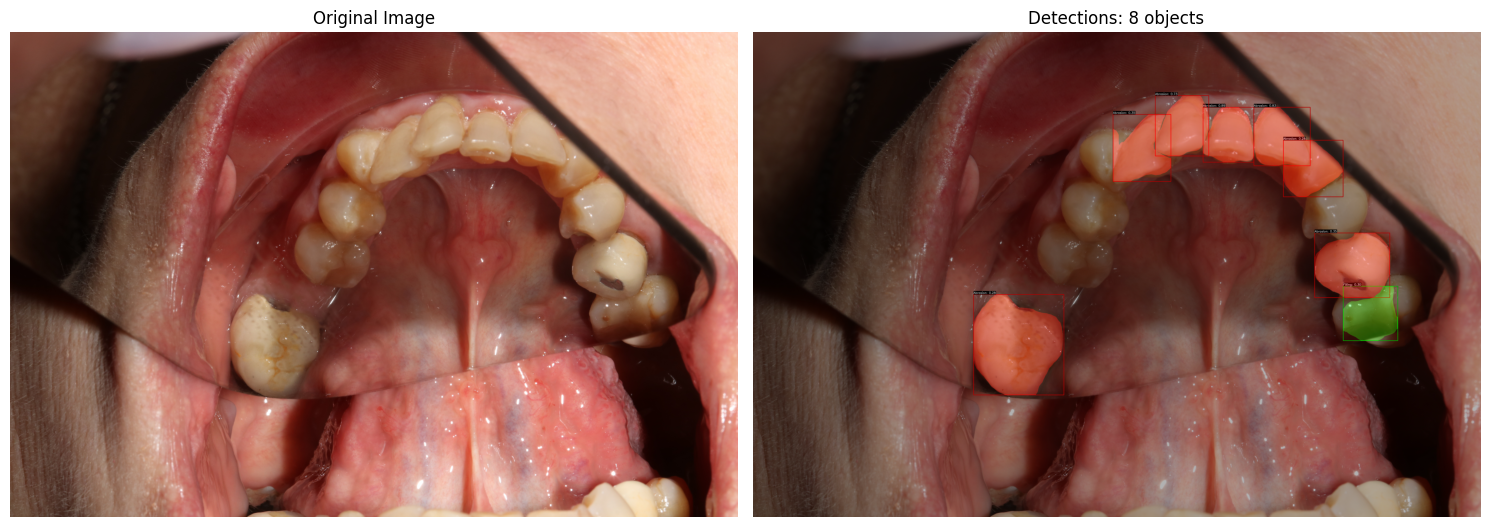

Found 8 detections:

Visualizing: test_101.jpg


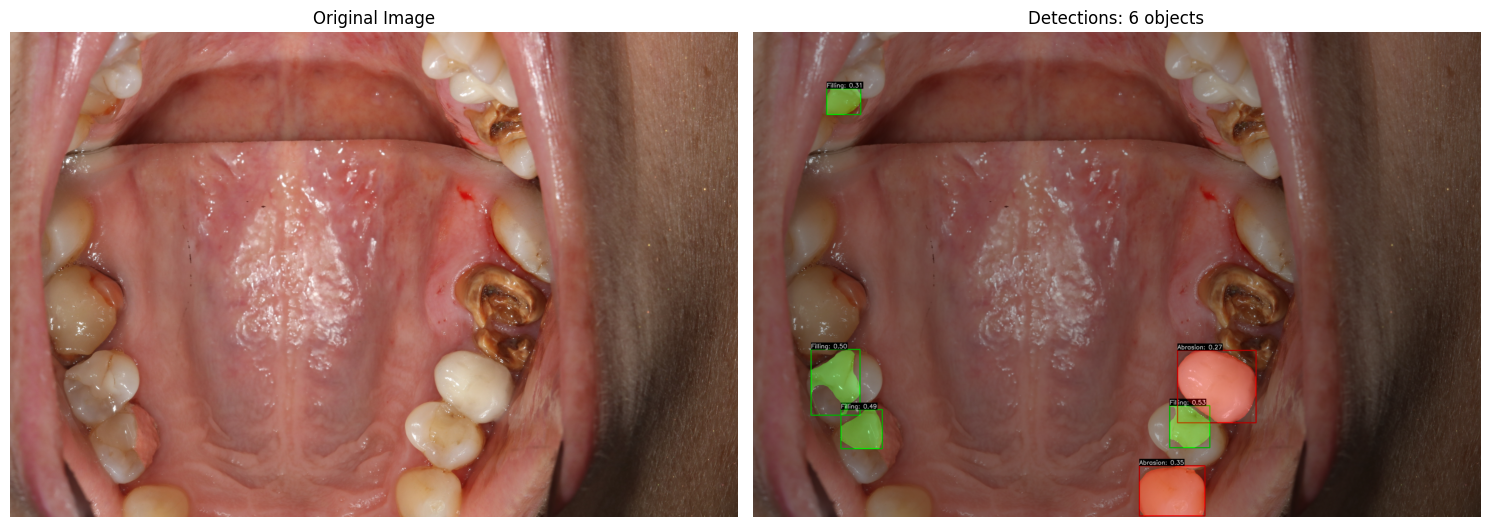

Found 6 detections:

Visualizing: test_030.jpg


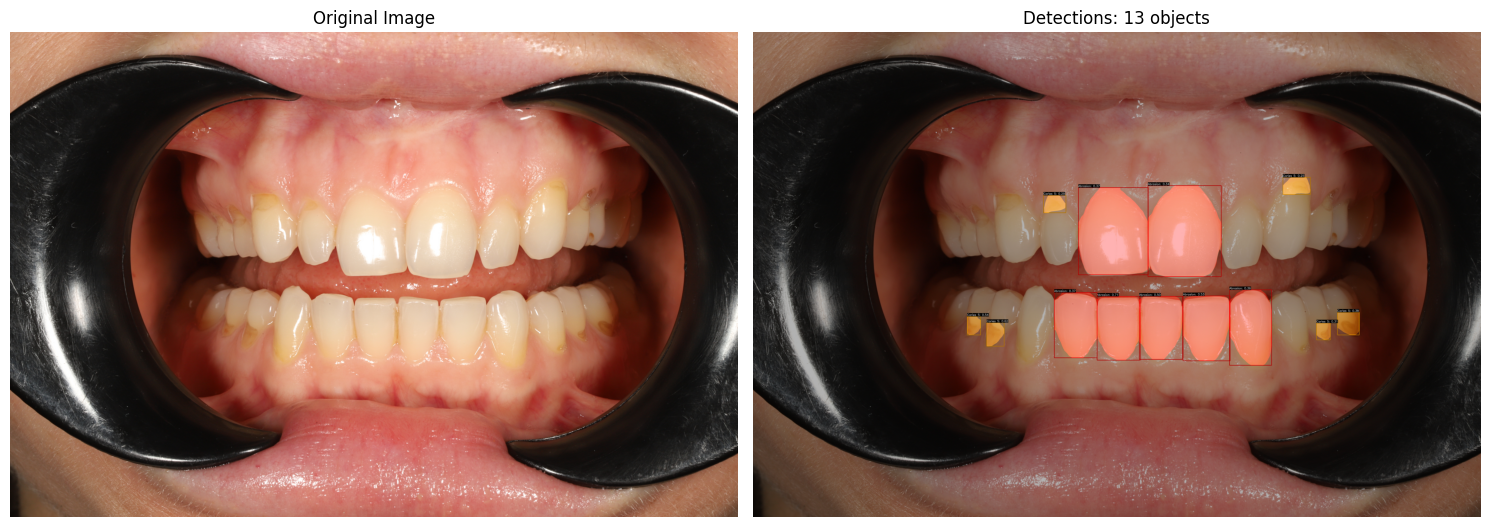

Found 13 detections:

Visualizing: test_034.jpg


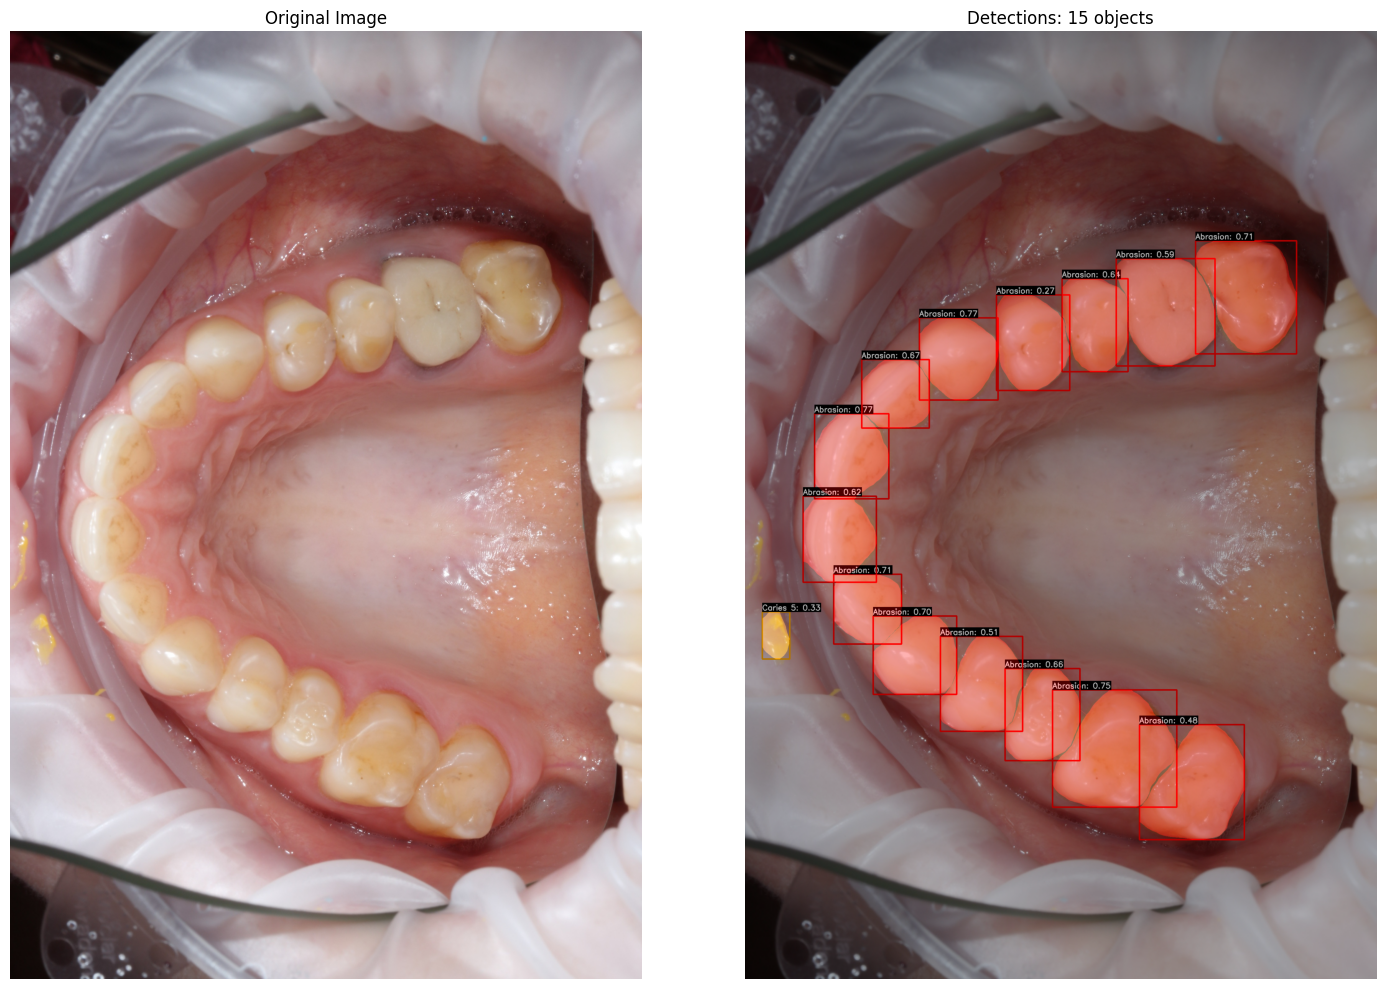

Found 15 detections:

Visualizing: test_115.jpg


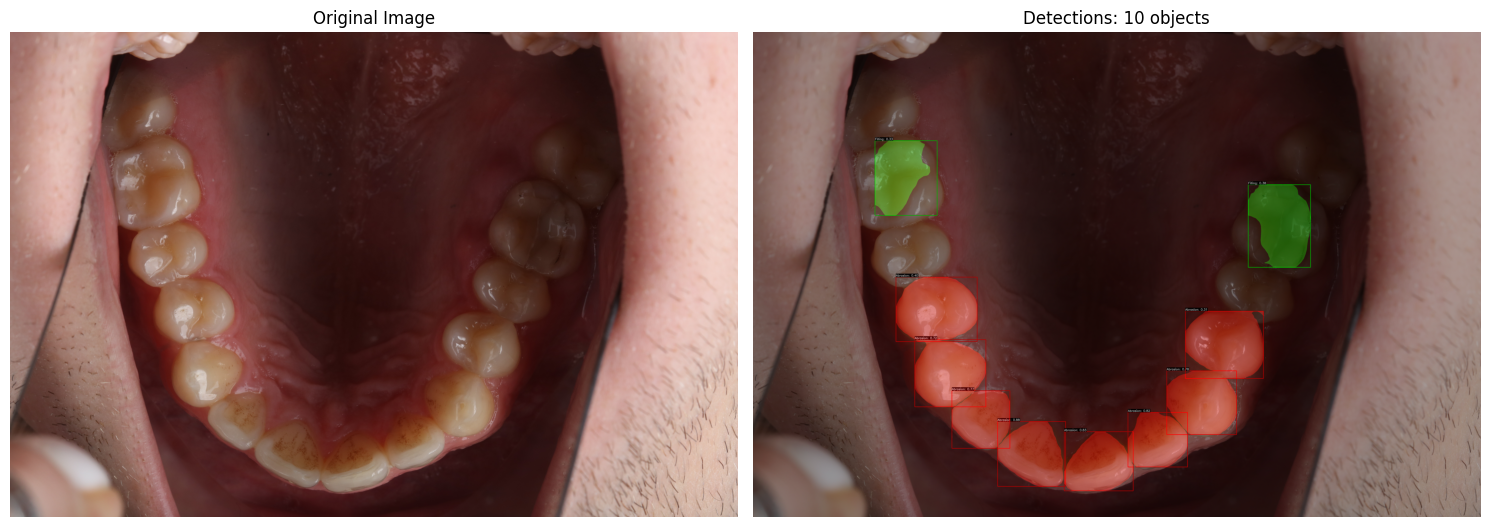

Found 10 detections:


In [52]:
import cv2
import matplotlib.pyplot as plt
from random import sample
import torch
import numpy as np
import os
from PIL import Image

def visualize_pipeline_results(yolo_model, rcnn_model, classifier, image_paths, class_names, num_samples=5, imgsz=640):
    """
    Visualize pipeline predictions on random sample images
    """
    # Transform for classifier
    clf_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # Move classifier to CPU
    classifier_cpu = classifier.to("cpu")
    
    # Randomly pick some images
    sample_paths = sample(image_paths, min(num_samples, len(image_paths)))
    
    # Color palette for different classes
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (128, 0, 128),  # Purple
        (255, 165, 0),  # Orange
        (0, 128, 128)   # Teal
    ]

    for img_path in sample_paths:
        print(f"\nVisualizing: {os.path.basename(img_path)}")
        
        try:
            # Run YOLO prediction
            yolo_results = yolo_model.predict(
                img_path, imgsz=imgsz, conf=0.25, iou=0.45,
                retina_masks=True, verbose=False
            )
            yolo_result = yolo_results[0]
            
            # Load image
            img_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_display = img_rgb.copy()
            h, w = img_display.shape[:2]
            
            if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
                print(f"No detections in {os.path.basename(img_path)}")
                plt.figure(figsize=(10, 8))
                plt.imshow(img_display)
                plt.axis('off')
                plt.title(f"No detections: {os.path.basename(img_path)}")
                plt.show()
                continue
            
            # Get YOLO results
            boxes = yolo_result.boxes.xyxy.cpu().numpy()
            yolo_classes = yolo_result.boxes.cls.cpu().numpy().astype(int)
            confidences = yolo_result.boxes.conf.cpu().numpy()
            masks_xy = yolo_result.masks.xy if yolo_result.masks is not None else []
            
            # Create overlay for masks
            mask_overlay = np.zeros_like(img_display)
            
            # Process each detection
            for i, (box, yolo_cls, conf) in enumerate(zip(boxes, yolo_classes, confidences)):
                x1, y1, x2, y2 = box.astype(int)
                final_cls = int(yolo_cls)
                
                # Refine classification if needed
                if yolo_cls == 3:
                    try:
                        crop = img_rgb[y1:y2, x1:x2]
                        if crop.size > 0:
                            crop_pil = Image.fromarray(crop).convert("RGB")
                            crop_tensor = clf_transform(crop_pil).unsqueeze(0)
                            
                            with torch.no_grad():
                                out = classifier_cpu(crop_tensor)
                                fine_cls = int(out.argmax(1).item())
                            final_cls = fine_cls + 3
                    except Exception as e:
                        print(f"Classifier error: {e}")
                
                # Get color for this class
                color = colors[final_cls % len(colors)]
                
                # Draw bounding box
                cv2.rectangle(img_display, (x1, y1), (x2, y2), color, 3)
                
                # Draw segmentation mask
                if i < len(masks_xy) and masks_xy[i] is not None:
                    polygon = masks_xy[i]
                    if len(polygon) >= 3:
                        # Convert to integer points
                        pts = np.array(polygon, dtype=np.int32)
                        # Fill polygon on overlay
                        cv2.fillPoly(mask_overlay, [pts], color)
                
                # Draw label
                class_name = class_names[final_cls] if final_cls < len(class_names) else f"Class_{final_cls}"
                label = f"{class_name}: {conf:.2f}"
                
                # Get text size for background
                (text_width, text_height), _ = cv2.getTextSize(
                    label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2
                )
                
                # Draw background rectangle for text
                cv2.rectangle(img_display, (x1, y1 - text_height - 10), 
                            (x1 + text_width, y1), (0, 0, 0), -1)
                
                # Draw text
                cv2.putText(img_display, label, (x1, y1 - 5), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
            # Blend mask overlay with original image
            img_with_masks = cv2.addWeighted(img_display, 0.7, mask_overlay, 0.3, 0)
            
            # Display result
            plt.figure(figsize=(15, 10))
            
            # Show original and result side by side
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title("Original Image")
            
            plt.subplot(1, 2, 2)
            plt.imshow(img_with_masks)
            plt.axis('off')
            plt.title(f"Detections: {len(boxes)} objects")
            
            plt.tight_layout()
            plt.show()
            
            # Print detection summary
            print(f"Found {len(boxes)} detections:")
            for i, (cls, conf) in enumerate(zip(yolo_classes, confidences)):
                final_cls = int(cls)
                if cls == 3:  # If it was refined
                    final_cls = i + 3  # This is simplified, you'd need to track actual refined classes
                class_name = class_names[final_cls] if final_cls < len(class_names) else f"Class_{final_cls}"
                # print(f"  - {class_name}: {conf:.3f}")
                
        except Exception as e:
            print(f"Error visualizing {img_path}: {e}")
            continue

# Visualize results
visualize_pipeline_results(
    yolo_model=yolo_model,
    rcnn_model=rcnn_model,
    classifier=classifier,
    image_paths=test_images,
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],
    num_samples=5  # Show 5 random images
)

## FINAL VALIDATION

In [55]:
def run_pipeline_for_eval(yolo_model, rcnn_model, classifier, image_paths, class_names, imgsz=640):
    all_preds = []
    
    rcnn_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    classifier = classifier.to("cpu")

    for img_idx, img_path in enumerate(image_paths):
        yolo_result = safe_predict_yolo(yolo_model, img_path, imgsz)
        if yolo_result is None:
            continue

        h, w = yolo_result.orig_shape
        if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
            continue

        boxes = yolo_result.boxes.xyxy.cpu().numpy()
        yolo_classes = yolo_result.boxes.cls.cpu().numpy().astype(int)
        confidences = yolo_result.boxes.conf.cpu().numpy()
        yolo_masks_xy = yolo_result.masks.xy if yolo_result.masks is not None else []

        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        for i, (box, yolo_cls, conf) in enumerate(zip(boxes, yolo_classes, confidences)):
            x1, y1, x2, y2 = box.astype(int)
            final_cls = int(yolo_cls)

            # classifier refinement
            if yolo_cls == 3:
                crop = img_rgb[y1:y2, x1:x2]
                if crop.size > 0:
                    crop_pil = Image.fromarray(crop).convert("RGB")
                    crop_tensor = clf_transform(crop_pil).unsqueeze(0)
                    with torch.no_grad():
                        out = classifier(crop_tensor)
                        fine_cls = int(out.argmax(1).item())
                    final_cls = fine_cls + 3

            # polygon extraction (prefer YOLO mask)
            poly_str = ""
            if i < len(yolo_masks_xy):
                polygon = yolo_masks_xy[i]
                if polygon is not None and len(polygon) >= 3:
                    normalized_coords = []
                    for point in polygon:
                        x_norm = float(point[0]) / w
                        y_norm = float(point[1]) / h
                        normalized_coords.extend([x_norm, y_norm])
                    poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

            # fallback to bbox
            if not poly_str:
                x1_norm, y1_norm = x1/w, y1/h
                x2_norm, y2_norm = x2/w, y2/h
                normalized_coords = [x1_norm, y1_norm, x2_norm, y1_norm, x2_norm, y2_norm, x1_norm, y2_norm]
                poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

            patient_id = os.path.splitext(os.path.basename(img_path))[0]
            all_preds.append({
                "image_id": patient_id,
                "class_id": final_cls,
                "confidence": float(conf),
                "polygon": poly_str
            })

    return all_preds
def load_ground_truth(labels_dir, image_paths):
    gt_data = []
    for img_path in image_paths:
        label_path = os.path.join(labels_dir, os.path.basename(img_path).replace(".jpg", ".txt"))
        if not os.path.exists(label_path):
            continue
        patient_id = os.path.splitext(os.path.basename(img_path))[0]
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                gt_data.append({
                    "image_id": patient_id,
                    "class_id": cls_id,
                    "polygon": coords
                })
    return gt_data
from shapely.geometry import Polygon

from shapely.geometry import Polygon
import numpy as np

def polygon_iou(poly1, poly2):
    """IoU between two polygons given as flat [x1,y1,x2,y2,...] normalized coords"""
    try:
        p1 = Polygon(np.array(poly1).reshape(-1, 2))
        p2 = Polygon(np.array(poly2).reshape(-1, 2))
        if not p1.is_valid or not p2.is_valid:
            return 0.0
        inter = p1.intersection(p2).area
        union = p1.union(p2).area
        return inter / union if union > 0 else 0.0
    except Exception:
        return 0.0


def evaluate_map(preds, gts, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    preds: list of {image_id, class_id, confidence, polygon}
    gts:   list of {image_id, class_id, polygon}
    """
    # group GT by image for fast lookup
    gt_by_img = {}
    for gt in gts:
        gt_by_img.setdefault(gt["image_id"], []).append(gt)

    aps = []
    aps_50 = []

    for thr in iou_thresholds:
        tp, fp, fn = 0, 0, 0
        matched = set()

        # sort predictions by confidence
        preds_sorted = sorted(preds, key=lambda x: -x["confidence"])

        for pred in preds_sorted:
            pid = pred["image_id"]
            pred_poly = list(map(float, pred["polygon"].split()))
            best_iou, best_gt_idx = 0, -1

            for j, gt in enumerate(gt_by_img.get(pid, [])):
                if gt["class_id"] != pred["class_id"] or (pid, j) in matched:
                    continue
                gt_poly = gt["polygon"]
                iou = polygon_iou(pred_poly, gt_poly)
                if iou > best_iou:
                    best_iou, best_gt_idx = iou, j

            if best_iou >= thr:
                tp += 1
                matched.add((pid, best_gt_idx))
            else:
                fp += 1

        # count FN
        total_gt = sum(len(v) for v in gt_by_img.values())
        fn = total_gt - len(matched)

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        ap = precision * recall  # crude AP approx
        aps.append(ap)
        if abs(thr - 0.5) < 1e-6:
            aps_50.append(ap)

    map_5095 = np.mean(aps)
    map_50 = np.mean(aps_50)
    return map_50, map_5095



In [56]:
# ====== Caller for Validation ======
def validate_pipeline(yolo_model, rcnn_model, classifier, image_paths, labels_dir, class_names, imgsz=640):
    print("🔎 Running prediction pipeline...")
    preds = run_pipeline_for_eval(
        yolo_model=yolo_model,
        rcnn_model=rcnn_model,
        classifier=classifier,
        image_paths=image_paths,
        class_names=class_names,
        imgsz=imgsz
    )

    print("📂 Loading ground-truth annotations...")
    gts = load_ground_truth(labels_dir, image_paths)

    print(f"✅ Predictions: {len(preds)}, GT objects: {len(gts)}")

    # Evaluate mAP
    print("📊 Evaluating mAP...")
    map50, map5095 = evaluate_map(preds, gts)

    print("\n=== Validation Results ===")
    print(f"mAP@50   : {map50:.4f}")
    print(f"mAP@50-95: {map5095:.4f}")
    return map50, map5095
# Example: run on validation set
map50, map5095 = validate_pipeline(
    yolo_model=yolo_model,
    rcnn_model=rcnn_model,
    classifier=classifier,
    image_paths=new_eval_images,            # list of validation image paths
    labels_dir=NEW_EVAL_LABELS_PATH,  # folder with polygon .txt labels
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],
    imgsz=640
)


🔎 Running prediction pipeline...
📂 Loading ground-truth annotations...
✅ Predictions: 1150, GT objects: 1140
📊 Evaluating mAP...

=== Validation Results ===
mAP@50   : 0.1714
mAP@50-95: 0.1216


In [64]:
def evaluate_polygon_length_diff(preds, gts, iou_thr=0.5):
    """
    Compute average difference in polygon length (# of vertices) 
    between matched predictions and ground truths.
    """
    gt_by_img = {}
    for gt in gts:
        gt_by_img.setdefault(gt["image_id"], []).append(gt)

    matched_diffs = []
    matched = set()

    preds_sorted = sorted(preds, key=lambda x: -x["confidence"])

    for pred in preds_sorted:
        pid = pred["image_id"]
        pred_poly = list(map(float, pred["polygon"].split()))
        best_iou, best_gt_idx = 0, -1

        for j, gt in enumerate(gt_by_img.get(pid, [])):
            if gt["class_id"] != pred["class_id"] or (pid, j) in matched:
                continue
            gt_poly = gt["polygon"]
            iou = polygon_iou(pred_poly, gt_poly)
            if iou > best_iou:
                best_iou, best_gt_idx = iou, j

        if best_iou >= iou_thr and best_gt_idx >= 0:
            matched.add((pid, best_gt_idx))
            gt_poly = gt_by_img[pid][best_gt_idx]["polygon"]

            # Compare polygon lengths (# of coords / 2)
            pred_len = len(pred_poly) // 2
            gt_len = len(gt_poly) // 2
            matched_diffs.append(pred_len - gt_len)

    avg_diff = np.mean(matched_diffs) if matched_diffs else 0.0
    return avg_diff, matched_diffs


In [70]:
preds = run_pipeline_for_eval(
        yolo_model=yolo_model,
        rcnn_model=rcnn_model,
        classifier=classifier,
        image_paths=new_eval_images,            # list of validation image paths
        class_names=[CLASS_INFO[i]['name'] for i in range(9)],
        imgsz=640
    )


In [69]:
labels_dir=NEW_EVAL_LABELS_PATH
gts = load_ground_truth(labels_dir, new_eval_images)
avg_diff, diffs = evaluate_polygon_length_diff(preds, gts, iou_thr=0.5)

print(f"📏 Average polygon length difference: {avg_diff:.2f} vertices")
print(f"All differences: {diffs}")


📏 Average polygon length difference: -165.68 vertices
All differences: [-116, -87, -321, -193, -309, -186, -126, -159, -163, -132, -212, -128, -144, -182, -27, -238, -181, 27, -630, -127, -131, -140, -113, -233, -101, -114, -158, -162, -151, -122, -126, -198, -172, -188, 34, -79, -227, -141, -182, -263, -117, -217, -144, -207, 19, -238, -4, -250, -232, -125, -160, -96, -109, -85, -168, -71, -269, -117, -158, -187, -105, -122, -226, -305, -228, -227, -278, -177, -137, -112, -84, -192, -266, -163, -139, -134, -141, -245, -29, 24, -243, -80, -97, -151, -92, -202, -69, -147, -114, -87, -197, -181, -41, -145, -244, -128, -204, -127, -147, -145, -49, -184, -314, -126, 72, -134, -280, -204, -167, -128, -207, -222, -89, -200, -80, -251, -90, -79, -138, -225, -81, -226, -188, -279, -101, -93, -307, -153, -158, -87, -140, -117, -56, -57, -79, -121, -261, -145, -94, -220, -98, 10, -83, -210, -148, -136, -219, -215, -296, -133, -182, -152, -273, -122, -207, -236, -95, -145, -178, -127, -222, -510,